<a href="https://colab.research.google.com/github/nluiscuadros24/predicci-n_de_radiacion-solar/blob/main/week_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from datetime import datetime
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline


from datetime import datetime
from sklearn.preprocessing import MinMaxScaler




In [122]:
df = pd.read_csv('Latacunga_2020-01-01_2020-01-31.csv',
                
                parse_dates=['Time'], 
                index_col=['Time']
)
df = df[["Solar Radiation Avg","Baro Avg","Hum Avg","Windspeed","Temp Avg"]]

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39149 entries, 2020-01-01 00:00:00 to 2020-01-31 22:23:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar Radiation Avg  39149 non-null  int64  
 1   Baro Avg             39149 non-null  float64
 2   Hum Avg              39149 non-null  int64  
 3   Windspeed            39149 non-null  float64
 4   Temp Avg             39149 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.8 MB


In [124]:
df.columns

Index(['Solar Radiation Avg', 'Baro Avg', 'Hum Avg', 'Windspeed', 'Temp Avg'], dtype='object')

In [125]:
df = df.resample('H').mean()

In [126]:
df.head()

,Solar Radiation Avg,Baro Avg,Hum Avg,Windspeed,Temp Avg
Time,,,,,
2020-01-01 00:00:00,0.0,720.426667,85.616667,3.288333,12.036667
2020-01-01 01:00:00,0.0,719.981667,81.300000,5.653333,11.985000
2020-01-01 02:00:00,0.0,719.441667,84.533333,3.043333,11.671667
2020-01-01 03:00:00,0.0,719.246667,87.300000,0.265000,11.465000
2020-01-01 04:00:00,0.0,719.328333,87.783333,2.021667,11.265000


In [127]:
dataset_train_actual = df.copy()

In [128]:
dataset_train_actual.isnull().sum()

Solar Radiation Avg    71
Baro Avg               71
Hum Avg                71
Windspeed              71
Temp Avg               71
dtype: int64

In [129]:
dataset_train_actual = dataset_train_actual.fillna(dataset_train_actual.mean())

In [132]:
dataset_train_actual = dataset_train_actual.reset_index()

In [133]:
dataset_train_actual.isnull().sum()

Time                   0
Solar Radiation Avg    0
Baro Avg               0
Hum Avg                0
Windspeed              0
Temp Avg               0
dtype: int64

In [114]:
#dataset_train_actual = dataset_train_actual.reset_index()

In [134]:
dataset_train_actual.head()

,Time,Solar Radiation Avg,Baro Avg,Hum Avg,Windspeed,Temp Avg
0,2020-01-01 00:00:00,0.0,720.426667,85.616667,3.288333,12.036667
1,2020-01-01 01:00:00,0.0,719.981667,81.300000,5.653333,11.985000
2,2020-01-01 02:00:00,0.0,719.441667,84.533333,3.043333,11.671667
3,2020-01-01 03:00:00,0.0,719.246667,87.300000,0.265000,11.465000
4,2020-01-01 04:00:00,0.0,719.328333,87.783333,2.021667,11.265000


In [135]:
dataset_train_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 743 non-null    datetime64[ns]
 1   Solar Radiation Avg  743 non-null    float64       
 2   Baro Avg             743 non-null    float64       
 3   Hum Avg              743 non-null    float64       
 4   Windspeed            743 non-null    float64       
 5   Temp Avg             743 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 35.0 KB


In [136]:
dataset_train_timeindex = dataset_train_actual.set_index('Time')

In [137]:
dataset_train = dataset_train_actual.copy()

In [229]:
#dataset_train = dataset_train[["Time","Temp Avg","Baro Avg","Hum Avg","Windspeed","Solar Radiation Avg"]]

dataset_train.head(15)

,Solar Radiation Avg,Baro Avg,Hum Avg,Windspeed,Temp Avg
0,0.000000,720.426667,85.616667,3.288333,12.036667
1,0.000000,719.981667,81.300000,5.653333,11.985000
2,0.000000,719.441667,84.533333,3.043333,11.671667
3,0.000000,719.246667,87.300000,0.265000,11.465000
4,0.000000,719.328333,87.783333,2.021667,11.265000
5,0.000000,719.776667,89.033333,1.611667,11.215000
6,3.350000,720.220000,89.700000,2.556667,11.220000
7,54.350000,720.936667,91.216667,2.881667,11.200000
8,167.900000,721.390000,84.800000,2.295000,12.415000
9,234.366667,721.515000,76.550000,5.963333,13.703333


In [139]:
cols = list(dataset_train)[1:6]
# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Time'])
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (743, 6)
All timestamps == 743
Featured selected: ['Solar Radiation Avg', 'Baro Avg', 'Hum Avg', 'Windspeed', 'Temp Avg']


In [140]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (743, 5).


array([[  0.        , 720.42666667,  85.61666667,   3.28833333,
         12.03666667],
       [  0.        , 719.98166667,  81.3       ,   5.65333333,
         11.985     ],
       [  0.        , 719.44166667,  84.53333333,   3.04333333,
         11.67166667],
       ...,
       [  0.        , 721.43095238,  88.38095238,   6.32857143,
         10.9       ],
       [180.91131793, 720.29844365,  77.72618259,  12.12879605,
         12.99322637],
       [  0.        , 721.95454545,  91.27272727,   5.3       ,
          9.3       ]])

In [141]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.83787459e-01],
       [-5.58664325e-01],
       [-5.74342877e-02],
       [ 2.35961483e-01],
       [ 6.43095936e-01],
       [ 7.24096122e-01],
       [ 4.43280762e-01],
       [ 4.69692267e-01],
       [ 8.80129137e-02],
       [ 5.57894063e-02],
       [-1.17099275e-01],
       [-5.26146539e-01],
       [-7.84670295e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.98574959e-01],
       [-7.53844611e-01],
       [-4.69718616e-01],
       [-6.74479768e-03],
       [ 8.37540525e-01],
       [ 1.20921441e+00],
       [ 2.44003468e+00],
       [ 1.65394295e+00],
       [-7.02354071e-02],
       [-1.7

In [169]:
X_train = []
y_train = []

n_future = 168   # Number of hours we want top predict into the future
n_past = 336     # Number of past hours we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (240, 336, 5).
y_train shape == (240, 1).


In [175]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [195]:
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [193]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          512       
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 64)          16640     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_7 (Lambda)            (None, 1)                 0         
Total params: 42,049
Trainable params: 42,049
Non-trainable params: 0
_________________________________________________________________


In [221]:
history = model.fit(X_train, y_train, shuffle=True, epochs=30, validation_split=0.2, verbose=1, batch_size=336)

Epoch 1/30
1/1 [==============================] - 1s 773ms/step - loss: 0.0586 - val_loss: 0.5380
Epoch 2/30
1/1 [==============================] - 1s 748ms/step - loss: 0.0724 - val_loss: 0.5471
Epoch 3/30
1/1 [==============================] - 1s 738ms/step - loss: 0.0714 - val_loss: 0.5546
Epoch 4/30
1/1 [==============================] - 1s 729ms/step - loss: 0.0647 - val_loss: 0.5591
Epoch 5/30
1/1 [==============================] - 1s 734ms/step - loss: 0.0600 - val_loss: 0.5587
Epoch 6/30
1/1 [==============================] - 1s 719ms/step - loss: 0.0593 - val_loss: 0.5559
Epoch 7/30
1/1 [==============================] - 1s 720ms/step - loss: 0.0589 - val_loss: 0.5495
Epoch 8/30
1/1 [==============================] - 1s 724ms/step - loss: 0.0654 - val_loss: 0.5414
Epoch 9/30
1/1 [==============================] - 1s 720ms/step - loss: 0.0782 - val_loss: 0.5329
Epoch 10/30
1/1 [==============================] - 1s 707ms/step - loss: 0.0566 - val_loss: 0.5255
Epoch 11/30
1/1 [==

In [222]:
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1h').tolist()


# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [223]:
datelist_train[-1]

Timestamp('2020-01-31 22:00:00')

In [224]:
datelist_future_

[datetime.date(2020, 1, 31),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 2),
 datetime.date(202

In [226]:
predictions_future = model.predict(X_train[-n_future:])

#predictions_train = model.predict(X_train[n_past:])

In [227]:
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
#y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Solar Radiation Avg']).set_index(pd.Series(datelist_future))
#PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Solar Radiation Avg']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

In [228]:
PREDICTIONS_FUTURE.head(11)

,Solar Radiation Avg
2020-01-31 22:00:00,-1.779844
2020-01-31 23:00:00,-0.448698
2020-02-01 00:00:00,7.164309
2020-02-01 01:00:00,11.320024
2020-02-01 02:00:00,12.410830
2020-02-01 03:00:00,12.066393
2020-02-01 04:00:00,17.311037
2020-02-01 05:00:00,45.164143
2020-02-01 06:00:00,185.942368
2020-02-01 07:00:00,427.131805


In [166]:
PREDICTION_TRAIN.head(10)

,Solar Radiation Avg
2020-01-23 19:00:00,207.567993
2020-01-23 20:00:00,115.095406
2020-01-23 21:00:00,26.829866
2020-01-23 22:00:00,88.127899
2020-01-23 23:00:00,174.749451
2020-01-24 00:00:00,136.031982
2020-01-24 01:00:00,51.794468
2020-01-24 02:00:00,-30.559477
2020-01-24 03:00:00,90.184830
2020-01-24 04:00:00,143.548767


Text(0, 0.5, 'Solar Radiation Avg Value')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


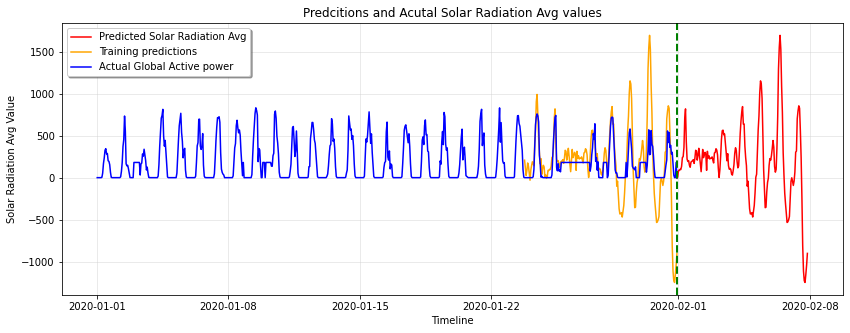

In [168]:
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2019-11-07'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Solar Radiation Avg'], color='r', label='Predicted Solar Radiation Avg')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Solar Radiation Avg'], color='orange', label='Training predictions')
plt.plot(dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:].index, dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:]['Solar Radiation Avg'], color='b', label='Actual Global Active power')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Solar Radiation Avg values', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Solar Radiation Avg Value', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
# plt.show()